<h1><center>Recommender Systems YSDA Course</center></h1>
<h1><center>Семинар №6</center></h1>

Семинарист: Владимир Байкалов

В этом семинаре мы поработаем с нейросетевыми подходами для кандидатогенерации. Реализуем одну из самых известных нейросетевых моделей для рекомендаций, SASRec, и сравним между собой различные способы обучения этой модели, их плюсы и минусы.

На этом семинаре мы познакомимся с нейронными рекомендательными системами на примере датасета MovieLens 1M. Мы научимся подготавливать данные, реализовывать модели рекомендаций, а также экспериментировать с различными функциями потерь, чтобы увидеть, как они влияют на качество и производительность моделей. В ходе семинара мы будем оценивать результаты и обсуждать, как выбор архитектуры и целевой функции влияет на итоговые рекомендации.

In [ ]:
import copy
import datetime
import numpy as np
import os
import pandas as pd
import polars as pl
import requests
import zipfile

from tqdm import tqdm
from typing import Tuple, Dict, List, Any

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## 📖 Про SASRec

<img src="https://recbole.io/docs/_images/sasrec.png" alt="drawing"/> 

### 🧐 **Что такое SASRec?**
SASRec (Self-Attentive Sequential Recommendation) - это нейросетевая модель для последовательных рекомендаций, основанная на архитектуре трансформера и механизме самовнимания (self-attention). Модель была предложена в 2018 году (Wang-Cheng Kang, Julian McAuley). Её цель - эффективно учитывать как краткосрочные, так и долгосрочные зависимости в последовательности действий пользователя, чтобы предсказывать его будущие интересы. SASRec адаптирует идеи self-attention из NLP для задачи рекомендаций, что позволяет ей быть одновременно интерпретируемой, масштабируемой и быстрой по сравнению с RNN и CNN. Оригинальная статья, которая описывает подход находится вот [тут](http://arxiv.org/abs/1808.09781).


### 👀 **Основные компоненты модели:**

- Embedding Layer: каждому объекту сопоставляется обучаемый эмбеддинг фиксированной размерности $d$. Также добавляются позиционное кодирование для учёта порядка событий.
- Transformer Encoder: последовательное применение $l$ блоков энкодера из трансфорера с каузальной маской. Каждый блок содержит self-attention слой и position-wise feed-forward слой, а также residual connection и layernorm.
- Prediction Layer: для каждой позиции $t$ выход энкодера $\mathbf{F}^{(b)}_t$ скалярно умножается на эмбеддинг каждого объекта каталога $\mathbf{M}_i$, чтобы получить скор релевантности $r{i, t}$ для каждого из айтемов.


### 🤔 **Что подаётся на вход?**
На вход SASRec получает последовательность последних $|S^u|$ взаимодействий пользователя: 

$$\Large{S^u = \left( S^u_1, S^u_2, \dots, S^u_{|S^u|} \right)},$$
где $S^u_t$ - идентификатор объекта (например, фильма или товара), с которым пользователь $u$ взаимодействовал в момент времени $t$.


### 🤷‍♀️ **Что предсказываем?**
Модель обучается предсказывать следующий объект в последовательности пользователя. Формально, для каждого $t$ она получает на вход $(S^u_1, ..., S^u_{t-1})$ и должна предсказать $S^u_t$.
Для каждого объекта $i$ из каталога вычисляется скор релевантности $r_{i, t}$ - показатель того, насколько именно этот объект подходит для того, чтобы быть следующим в момент времени $t$:

$$\Large{r_{i, t} = \langle F_t^{l}, M_i \rangle},$$

где $\mathbf{F}_t^{l}$ - выход l-го слоя энкодера для позиции $t$, а $\mathbf{M}_i$ - эмбеддинг объекта $i$.


# 🗂️ Подготовка данных

## 🎥 **Датасет: MovieLens-1M**

Классический набор данных для тестирования алгоритмов рекомендательных систем, собранный исследовательской группой GroupLens Университета Миннесоты в 2003 году. 

Он содержит 1 000 209 анонимных оценок от 6 040 пользователей для примерно 3 900 фильмов и является одним из самых популярных бенчмарков в исследованиях коллаборативной фильтрации.

### Структура данных
Данные разделены на три файла в формате .dat с разделителем `::`
1. `ratings.dat`
- UserID: уникальный идентификатор пользователя (от 1 до 6040)
- MovieID: уникальный идентификатор фильма (от 1 до 3952)
- Rating: целочисленная оценка по 5-звёздочной шкале (1–5)
- Timestamp: время оценки в секундах с 1 января 1970 года.
- Каждый пользователь оценил не менее 20 фильмов, что снижает проблему холодного старта.

2. `users.dat`
- Gender: пол (M/F)
- Age: возрастная категория (7 групп): 1: <18, 18: 18–24, 25: 25–34, 35: 35–44, 45: 45–49, 50: 50–55, 56: 56+.
- Occupation: род занятий (21 категория, включая "учёный", "инженер", "студент").
- Zip-code: почтовый индекс.
3. `movies.dat`
- Title: название с годом выпуска (например, Toy Story (1995)).
- Genres: до 18 жанров через | (например, Action|Comedy|Sci-Fi). 
- Основные жанры: Action, Drama, Comedy, Thriller, Romance, Documentary.

In [ ]:
# Функция из первого семинара
def download_and_extract(url: str, filename: str, chunk_size: int = 1024):
    # Скачивание файла
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    total_size = int(response.headers.get('content-length', 0))
    
    # Запись файла
    with open(filename, "wb") as f:
        with tqdm(
            total=total_size,
            unit='B',
            unit_scale=True,
            desc=filename,
            bar_format='{l_bar}{bar:50}{r_bar}{bar:-50b}'  # Формат для красоты
        ) as pbar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    
    # Распаковка архива
    with zipfile.ZipFile(filename, "r") as zip_ref:
        print(f"\nРаспаковываем {filename}...")
        zip_ref.extractall(".")
        print(f"Файлы из {filename} успешно извлечены\n")

In [ ]:
download_and_extract(
    url="http://files.grouplens.org/datasets/movielens/ml-1m.zip",
    filename="ml-1m.zip"
)

In [ ]:
dataset_path = './ml-1m/'

# Все рейтинги
ratings = pd.read_csv(
    os.path.join(dataset_path, 'ratings.dat'),
    delimiter='::',
    header=None,
    names=['user_id', 'movie_id', 'rating', 'timestamp'],
    engine='python'
)
ratings = pl.from_pandas(ratings)

# Информация про фильмы
movies = pd.read_csv(
    os.path.join(dataset_path, 'movies.dat'),
    delimiter='::',
    header=None,
    names=['movie_id', 'title', 'genres'],
    encoding='latin-1',
    engine='python'
)
movies = pl.from_pandas(movies)

# Информация про пользователей
users = pd.read_csv(
    os.path.join(dataset_path, 'users.dat'),
    delimiter='::',
    header=None,
    names=['user_id', 'gender', 'age', 'occupation', 'zip_code'],
    engine='python'
)
users = pl.from_pandas(users)

In [ ]:
ratings.head()

## 🔍 Про предобработку датасетов для обучения моделей

В современных исследованиях рекомендательных систем используется стандартизированный конвейер предобработки данных, направленный на повышение качества моделей и воспроизводимости результатов

Во многих статьях по рекомендательным системам используется устоявшаяся схема предобработки датасетов:

1. **Фильтрация редких сущностей**: Удаляются пользователи и айтемы (товары/фильмы/etc), у которых количество взаимодействий меньше определенного порога. Это снижает разреженность матрицы взаимодействий и минимизирует шум. Для датасетов Amazon, которые довольно популярны в академии, есть специальная нотация "5-core"

2. **Стратегии разделения данных**: В оригинальное работе используется leave-one-out, но мы сделаем time-split.

3. **Процесс обучения и оценки**: Будем использовать обучающую выборку для поиска лучших весов модели, валидационную -- для подброра гиперпараметров и early-stopping'а, на тестовой будем получать финальные метрики.

## 1️⃣ Фильтрация пользователей и айтемов

In [ ]:
filtering_stage = 0
is_changed = True
threshold = 5
good_users = set()
good_items = set()

filtered_ratings = ratings.clone()

# Цикл фильтрации
while is_changed:
    user_counts = filtered_ratings.group_by('user_id').agg(pl.len().alias('user_count'))
    movie_counts = filtered_ratings.group_by('movie_id').agg(pl.len().alias('movie_count'))

    good_users = user_counts.filter(pl.col('user_count') >= threshold).select('user_id')
    good_movies = movie_counts.filter(pl.col('movie_count') >= threshold).select('movie_id')

    old_size = len(filtered_ratings)

    new_ratings = filtered_ratings.join(good_users, on='user_id', how='inner')
    new_ratings = new_ratings.join(good_movies, on='movie_id', how='inner')

    new_size = len(new_ratings)
    
    filtered_ratings = new_ratings
    is_changed = old_size != new_size
    filtering_stage += 1

# Переводим id объектов в `плотные` числа
filtered_ratings = filtered_ratings.with_columns(movie_id = pl.col('movie_id').rank('dense') - 1)
filtered_ratings = filtered_ratings.sort(['user_id', 'timestamp'])

grouped_filtered_df = filtered_ratings.group_by('user_id', maintain_order=True).agg(
    pl.all().exclude('user_id')
)

In [ ]:
print('Количество пользователей:', len(filtered_ratings.group_by('user_id').len()))
print('Количество фильмов:', len(filtered_ratings.group_by('movie_id').len()))
print('Количество взаимодействий:', filtered_ratings.shape[0])
print('Средняя длина пользовательской истории:', round(np.mean(list(map(lambda x: x[0], grouped_filtered_df.select(pl.col('movie_id').list.len()).rows()))), 3))

### 📝 Пример статистик после фильтрации для сравнения

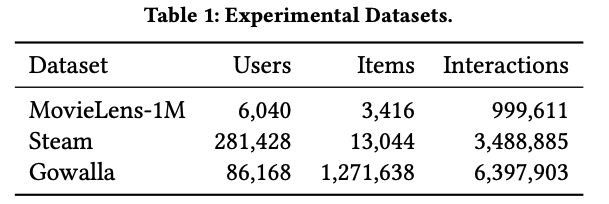

## 2️⃣ Разделение данных на обучающую, валидационную и тестовую выборки

Будем брать (80% для обучения, 10% для валидации, 10% для теста), будем использовать разделение по времени (time-split).

In [ ]:
filtered_ratings.head()

In [ ]:
valid_portion = 0.1
test_portion = 0.1

all_events_timestamp = []
for _, _, _, timestamp in filtered_ratings.iter_rows():
    all_events_timestamp.append(timestamp)

all_events_timestamp = sorted(all_events_timestamp)

fst_threshold = all_events_timestamp[int(len(all_events_timestamp) * (1.0 - test_portion - valid_portion))]
snd_threshold = all_events_timestamp[int(len(all_events_timestamp) * (1.0 - test_portion))]

print(f'Первый таймстемп на обучающей выборке:\t\t{datetime.datetime.fromtimestamp(all_events_timestamp[0])}')
print(f'Первый таймстемп на валидационной выборке:\t{datetime.datetime.fromtimestamp(fst_threshold)}')
print(f'Первый таймстемп на тестовой выборке:\t\t{datetime.datetime.fromtimestamp(snd_threshold)}')
print(f'Последний таймстемп:\t\t\t\t{datetime.datetime.fromtimestamp(all_events_timestamp[-1])}')

## 3️⃣ Сборка train-val-test датасетов

In [ ]:
train_data = []
valid_data = []
eval_data = []


for user_id, item_history, rating, timestamp in grouped_filtered_df.iter_rows():
    train_history = []
    history = []
    history_ts = []
    
    for item_id, ts in zip(item_history, timestamp):
        if ts < fst_threshold: # Это обучение
            assert len(history) == 0 or ts >= history_ts[-1]
            train_history.append(item_id)
        elif ts < snd_threshold: # Уже валидация
            assert len(history) == 0 or ts >= history_ts[-1]
            if len(history) >= 1:  # Берем только семплы длины 5 и более
                valid_data.append({
                    'user_id': user_id,
                    'history': [x for x in history + [item_id]]
                })
        else:  # Теперь эвал
            assert len(history) == 0 or ts >= history_ts[-1]
            if len(history) >= 1:  # Берем только семплы длины 5 и более
                eval_data.append({
                    'user_id': user_id,
                    'history': [x for x in history + [item_id]]
                })

        history.append(item_id)
        history_ts.append(ts)
    
    if len(train_history) >= 5:  # Берем только семплы длины 5 и более
        train_data.append({
            'user_id': user_id,
            'history': train_history
        })

In [ ]:
len(train_data), len(valid_data), len(eval_data)

## 🗃 Подготовка данных для поставки их в модель. Реализация Dataset и DataLoader

Мы подготовили данные, но чтобы наконец начать обучение нам надо еще реализовать `Dataset` и `Dataloader`. Тогда мы сможешь просто итерироваться по последнему, получать батчи и обучать на них наши модели.

Семплы (пользователи), которых мы будем передавать в модель будут иметь следующую структуру:

- history
    - item_ids (исторические взаимодействия пользователя)
    - lengths (количество взаимодействий в истории пользователя)
    - positions (номера позиций в обратном порядке)
- positive
    - item_ids (позитив, котороый модель должна предсказать, a.k.a следующее взаимодействие)
- negative
    - item_ids (случайно выбранный идентификатор айтема)

Разница будет лишь в том, что `Dataset` будет выдавать просто семплы по одному, а `Dataloader` будет конкатить все семплы из батча в 'спарсовый' формат.

In [ ]:
class MovieLensDataset(Dataset):
    def __init__(
            self, 
            data: List[Dict],
            num_items: int,
            max_seq_len: int,
        ) -> None:
        super().__init__()
        self.data = data
        self.num_items = num_items
        self.max_seq_len = max_seq_len

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Dict[str, List[int]]:
        sample = self.data[index]
        items = list(map(int, sample['history']))

        result = {}

        # Оставляем последние `max_seq_len` событий для истории и предсказаний
        item_sequence = items[:-1][-self.max_seq_len:]
        next_item_sequence = items[1:][-self.max_seq_len:]
        # Семплируем случайные негативы для каждого из позитивов
        random_negative_ids = np.random.randint(0, self.num_items, size=(len(item_sequence,))).tolist()

        result['history'] = dict(
            item_ids=item_sequence,
            lengths=len(item_sequence),
            positions=np.arange(start=len(item_sequence) - 1, stop=-1, step=-1).tolist()
        )

        # Позитивы и негативы для обучения
        result['positives'] = dict(
            item_ids=next_item_sequence
        )
        result['negatives'] = dict(
            item_ids=random_negative_ids
        )

        return result


In [ ]:
def collate_fn(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    result = {}
    keys = batch[0].keys()
    for key in keys:
        values = [item[key] for item in batch]
        first = values[0]
        if isinstance(first, dict):
            result[key] = collate_fn(values)
        elif isinstance(first, list):
            result[key] = torch.tensor(sum(values, []), dtype=torch.long)
        else:
            result[key] = torch.tensor(values, dtype=torch.long)
    return result

In [ ]:
NUM_ITEMS = 3416
MAX_SEQ_LEN = 5

tmp_dataset = MovieLensDataset(data=train_data, num_items=NUM_ITEMS, max_seq_len=MAX_SEQ_LEN)

In [ ]:
tmp_iter = iter(tmp_dataset)
print(next(tmp_iter))
print(next(tmp_iter))
print(next(tmp_iter))

In [ ]:
BATCH_SIZE = 3

tmp_dataloader = DataLoader(dataset=tmp_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn)

In [ ]:
print(next(iter(tmp_dataloader)))

## 🚀 Написание модели. Реализация алгоритма SASRec

In [ ]:
def get_mask(lengths: torch.Tensor) -> torch.Tensor:
    maxlen = lengths.max().item()
    return torch.arange(maxlen, device=lengths.device).expand(len(lengths), maxlen) < lengths.unsqueeze(1)


def get_last(data: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
    offsets = torch.cumsum(lengths, dim=-1)
    return data[offsets - 1]

In [ ]:
class SasRecBackbone(nn.Module):
    def __init__(
            self,
            num_items: int,
            embedding_dim: int = 64,
            num_heads: int = 2,
            max_seq_len: int = 512,
            dropout_rate: float = 0.2,
            num_transformer_layers: int = 2,
        ) -> None:
        super().__init__()
        self.num_items = num_items
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.item_encoder = nn.Embedding(
            num_embeddings=num_items,
            embedding_dim=embedding_dim
        )
        self.position_embeddings = nn.Embedding(
            num_embeddings=max_seq_len,
            embedding_dim=embedding_dim
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=embedding_dim * 4,
            dropout=dropout_rate,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_transformer_layers)
    
    @property
    def catalog_embeddings(self) -> torch.Tensor:
        return self.item_encoder.weight.data

    def forward(self, inputs: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        item_embeddings = self.item_encoder(inputs['history']['item_ids'])  # (total_batch_events, embedding_dim)
        padding_mask = get_mask(inputs['history']['lengths'])  # (batch_size, seq_len)
        batch_size, seq_len = padding_mask.shape

        token_embeddings = item_embeddings.new_zeros(
            batch_size, seq_len, self.embedding_dim
        )  # (batch_size, seq_len, embedding_dim)
        token_embeddings[padding_mask] = (
            item_embeddings
            + self.position_embeddings(inputs['history']['positions'])
        )
        encoder_output = self.transformer_encoder(
            src=token_embeddings,
            mask=torch.triu(
                torch.ones((seq_len, seq_len), dtype=torch.bool, device=token_embeddings.device),
                diagonal=1
            ),
            src_key_padding_mask=~padding_mask,
            is_causal=True
        )[padding_mask]

        return {
            'encoder_output': encoder_output,
        }

In [ ]:
class SASRecModel(nn.Module):    
    def __init__(
            self,
            backbone: SasRecBackbone,
        ) -> None:
        super().__init__()
        self.backbone = backbone 
        self.init_weights(0.02)
    
    @torch.no_grad()
    def init_weights(self, initializer_range: float = 0.02) -> None:
        for key, value in self.named_parameters():
            if 'weight' in key:
                if 'norm' in key:
                    nn.init.ones_(value.data)
                else:
                    nn.init.trunc_normal_(
                        value.data,
                        std=initializer_range,
                        a=-2 * initializer_range,
                        b=2 * initializer_range
                    )
            elif 'bias' in key:
                nn.init.zeros_(value.data)
            else:
                raise ValueError(f'Unknown weight: {key}')
    
    def compute_loss(self, inputs: Dict, backbone_output: Dict) -> Dict:
        raise NotImplementedError
        
    def forward(self, inputs: Dict):
        backbone_outputs = self.backbone(inputs)

        if self.training:
            loss = self.compute_loss(inputs, backbone_outputs)
            return {
                'loss': loss
            }
        else:
            last_embeddings = get_last(
                data=backbone_outputs['encoder_output'],
                lengths=inputs['history']['lengths']
            )  # (batch_size, embedding_dim)
            candidate_scores = last_embeddings @ self.backbone.catalog_embeddings.T  # (batch_size, num_items)
            return {
                'candidate_scores': candidate_scores
            }


# 💻 Реализуем различные способы обучения SASRec'а

### 🤔 **Что подаётся на вход?**
На вход SASRec получает последовательность последних $|S^u|$ взаимодействий пользователя: 

$$\Large{S^u = \left( S^u_1, S^u_2, \dots, S^u_{|S^u|} \right)},$$
где $S^u_t$ - идентификатор объекта (например, фильма или товара), с которым пользователь $u$ взаимодействовал в момент времени $t$.


### 🤷‍♀️ **Что предсказываем?**
Модель обучается предсказывать следующий объект в последовательности пользователя. Формально, для каждого $t$ она получает на вход $(S^u_1, ..., S^u_{t-1})$ и должна предсказать $S^u_t$.
Для каждого объекта $i$ из каталога вычисляется скор релевантности $r_{i, t}$ - показатель того, насколько именно этот объект подходит для того, чтобы быть следующим в момент времени $t$:

$$\Large{r_{i, t} = \langle F_t^{l}, M_i \rangle},$$

где $\mathbf{F}_t^{l}$ - выход l-го слоя энкодера для позиции $t$, а $\mathbf{M}_i$ - эмбеддинг объекта $i$.


## 🤓 Оригинальный SASRec из статьи

В оригинальной статье предлагалось использовать функцию потерь BCE (Binary Cross Entropy):

$$\Large{\mathcal{L}_{Original} = - \sum_{S^u \in S} \sum_{t \in [1, 2, \dots, |S^u| - 1]} \Bigg[ \log \sigma \left( r_{S^u_{t+1}, t} \right)  + \sum_{j \notin S^u} \log \left( 1 - \sigma \left( r_{j,t} \right)   \right)} \Bigg],$$

где $\sigma(r_{i,t})$ - вероятность того, что айтем $i$ будет следующим в момент времени $t$, а $\sigma$ - сигмоидная функция.

$\color{red}{\text{Но на самом деле внутренней суммы нет, в статье используется один негатив на один позитив}}$

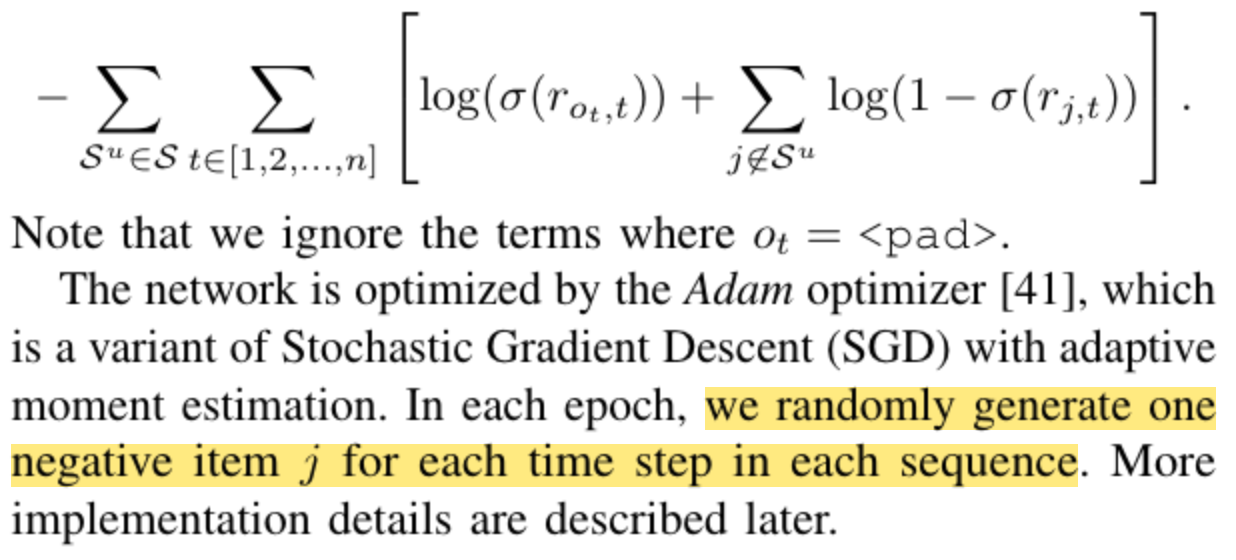

In [ ]:
class SasRecReal(SASRecModel):
    def compute_loss(self, inputs: Dict, backbone_output: Dict) -> torch.Tensor:
        query_embeddings = backbone_output['encoder_output']  # (total_batch_events, embedding_dim)
        positive_embeddings = self.backbone.item_encoder(inputs['positives']['item_ids'])  # (total_batch_events, embedding_dim)
        negative_embeddings = self.backbone.item_encoder(inputs['negatives']['item_ids'])  # (total_batch_events, embedding_dim)

        positive_scores = (query_embeddings * positive_embeddings).sum(dim=-1)  # (total_batch_events)
        negative_scores = (query_embeddings * negative_embeddings).sum(dim=-1)  # (total_batch_events)
        
        # Явно используем mean по умолчанию, так как при изменении размера батча итоговое значение лосса не будет зависеть от числа элементов в батче. 
        # Это делает обучение более стабильным и не требует пересчёта learning rate при изменении batch size.
        # Cреднее значение лосса позволяет сравнивать значения лосса между разными батчами и экспериментами независимо от их размера.
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            input=torch.cat([positive_scores, negative_scores], dim=0),
            target=torch.cat([torch.ones_like(positive_scores), torch.zeros_like(negative_scores)]),
            reduction='mean'
        )  # (1)
        
        return loss
        

## 🧐 SASRec через softmax по всему каталогу 

Давайте теперь реализуем вариант с использованием всего каталога для подсчета лосса. Здесь мы применим полный софтмакс

$$\Large{\mathcal{L}_{Full Softmax} = - \sum_{S^u \in S_B} \sum_{t \in [1, 2, \dots, |S^u| - 1]}  \Bigg[  - \log \left( \frac{e^{r_{S^u_{t+1}, t}}}{\sum_{d \in D}{e^{r_{d, t}}}} \right) \Bigg]},$$

где $D$ - весь каталог айтемов.

In [ ]:
class SasRecFull(SASRecModel):
    def compute_loss(self, inputs: Dict[str, torch.Tensor], backbone_output: Dict[str, torch.Tensor]) -> torch.Tensor:
        all_sample_embeddings = backbone_output['encoder_output']  # (total_batch_events, embedding_dim)
        all_positive_sample_events = inputs['positives']['item_ids']  # (total_batch_events)
        
        all_scores = all_sample_embeddings @ self.backbone.catalog_embeddings.T # (total_batch_events, num_items)

        loss = torch.nn.functional.cross_entropy(
            input=all_scores,
            target=all_positive_sample_events,
            reduction='mean'
        )  # (1)
        
        return loss


## 😇 SASRec через использование in-batch негативов

Все же использовать полный софтмакс не всегда представляется возможным и рандомно семплировать объекты из всего каталога может быть нетривиально. Попробуем решить эти проблемы и использовать только то, что мы получаем на вход модели в батче.

$$\Large{\mathcal{L}_{In-batch} = - \sum_{S^u \in S} \sum_{t \in [1, 2, \dots, n]}  \Bigg[  - \log \left( \frac{e^{r_{S^u_{t+1}, t}}}{e^{r_{S^u_{t+1}, t}} + \sum_{d \in Sample(B, k)}{e^{r_{d, t}}}} \right) \Bigg]},$$

где $k$ - количество негативов, для каждого семпла, $B$ - набор из всех идентификаторов в батче.


In [ ]:
class SasRecInBatch(SASRecModel):
    def __init__(
            self,
            backbone: SasRecBackbone,
            num_negatives: int
        ) -> None:
        super().__init__(backbone)
        self.num_negatives = num_negatives

    def compute_loss(self, inputs: Dict[str, torch.Tensor], backbone_output: Dict[str, torch.Tensor]) -> torch.Tensor:
        all_positive_sample_events = inputs['positives']['item_ids']  # (total_batch_events)

        # Семплируем негативы из текущего батча
        inbatch_negative_ids = torch.randperm(all_positive_sample_events.shape[0], device=all_positive_sample_events.device)[:self.num_negatives]  # (num_negatives)

        query_embeddings = backbone_output['encoder_output']  # (total_batch_events, embedding_dim)
        positive_embeddings = self.backbone.item_encoder(inputs['positives']['item_ids'])  # (total_batch_events, embedding_dim)

        inbatch_negative_embeddings = self.backbone.item_encoder(all_positive_sample_events[inbatch_negative_ids])  # (num_negatives, embedding_dim)

        positive_scores = (query_embeddings * positive_embeddings).sum(dim=-1)  # (total_batch_events)
        negative_scores = query_embeddings @ inbatch_negative_embeddings.T  # (total_batch_events, num_negatives)

        all_scores = torch.cat([positive_scores[:, None], negative_scores], dim=1)  # (all_batch_items, num_negatives + 1)
        all_scores = nn.functional.log_softmax(all_scores, dim=1)  # (all_batch_items, num_negatives + 1)
        loss = -all_scores[:, 0].mean()  # (1)
        
        return loss


## 🤩 SASRec с добавлением log-q коррекции в in-batch подход

Для добавления log-q коррекции нам надо изменить только одну вещь: нам надо использовать скорректированную релевантность для негативов:

$$ r^{*}_{i, t} = r_{i, t} - \log_2(Q(i)),$$

где $\large{Q(i) = \frac{\#i}{\#all}}$ - доля взаимодействий с айтемом $i$.

In [ ]:
def compute_item_statistics(num_items, dataset):
    counter = [0] * num_items
    all_cnt = 0
    for sample in dataset:
        for item_id in sample['history']['item_ids']:
            counter[item_id] += 1
            all_cnt += 1
    counter[0] = 0
    return counter, all_cnt


In [ ]:
class SasRecInBatchWithLogQ(SASRecModel):
    def __init__(
            self,
            backbone: SasRecBackbone,
            num_negatives: int,
            item_corrections: torch.Tensor
        ) -> None:
        super().__init__(backbone=backbone)
        self.num_negatives = num_negatives
        self.item_corrections = item_corrections

    def apply_correction(self, scores: torch.Tensor, ids: torch.Tensor) -> torch.Tensor:
        return scores - torch.log(self.item_corrections[ids] + 1e-9)[None]

    def compute_loss(self, inputs: Dict[str, torch.Tensor], backbone_output: Dict[str, torch.Tensor]) -> torch.Tensor:
        all_positive_sample_events = inputs['positives']['item_ids']  # (total_batch_events)
        inbatch_negative_ids = torch.randperm(all_positive_sample_events.shape[0], device=all_positive_sample_events.device)[:self.num_negatives]  # (num_negatives)

        query_embeddings = backbone_output['encoder_output']  # (total_batch_events, embedding_dim)
        positive_embeddings = self.backbone.item_encoder(inputs['positives']['item_ids'])  # (total_batch_events, embedding_dim)

        inbatch_negative_embeddings = self.backbone.item_encoder(all_positive_sample_events[inbatch_negative_ids])  # (num_negatives, embedding_dim)

        positive_scores = (query_embeddings * positive_embeddings).sum(dim=-1)  # (total_batch_events)

        # Изменили только скоры для негативов в сравнении с предыдущим подходом
        negative_scores = self.apply_correction(
            scores=query_embeddings @ inbatch_negative_embeddings.T,
            ids=all_positive_sample_events[inbatch_negative_ids]
        )  # (total_batch_events, num_negatives)

        all_scores = torch.cat([positive_scores[:, None], negative_scores], dim=1)  # (all_batch_items, num_negatives + 1)
        all_scores = nn.functional.log_softmax(all_scores, dim=1)  # (all_batch_items, num_negatives + 1)
        loss = -all_scores[:, 0].mean()  # (1)
        
        return loss

## 🎯 Метрики

Для того, чтобы понимать насколько хорошо работает наша модель, нам нужно определиться с метриками, который мы хотим считать на валидации и тесте. В рамках данного семинара предлагается использовать следующие метрики:

$$\text{HitRate@k} = \frac{1}{|S|} \sum_{S^u \in S}{ \mathbb{I} [ \text{positive} \in \text{recommended}[:\text{k}]] },$$

$$\text{DCG@k} = \frac{1}{|S|}\sum_{S^u \in S}{}{\sum_{i = 1}^{k} \frac{\mathbb{I} [ \text{recommended}^u_i = \text{positive} ] }{\log_2(i + 1)}},$$

$$\text{Coverage@k} = \frac{ \bigcup_{S^u \in S}{ \bigcup_{i=1}^{k}{ \text{recommended}^u_i}} }{|\mathcal{I}|},$$

где $\text{positive}$ - следующее позитивное взаимодействие, а $\text{recommended}$ - упорядоченная выдача, список айдишников упорядоченный по убыванию. $\mathcal{I}$ - весь каталог айтемов.

Важно заметить, что так как у нас только один позитив, то для нашего случая $\text{HitRate@k} = \text{Recall@k}$ и $\text{DCG@k} = \text{nDCG@k}$


In [ ]:
def compute_hitrate(indices: torch.Tensor, labels: torch.Tensor, k: int) -> List[float]:
    assert indices.shape[0] == labels.shape[0]
    hits = torch.eq(indices[:, :k], labels[..., None]).float()  # (n, k)
    hitrate = hits.sum(dim=-1)  # (n)
    return np.mean(hitrate.cpu().tolist())  # (1)


def compute_dcg(indices: torch.Tensor, labels: torch.Tensor, k: int) -> List[float]:
    assert indices.shape[0] == labels.shape[0]
    hits = torch.eq(indices[:, :k], labels[..., None]).float()  # (n, k)
    discount_factor = 1 / torch.log2(torch.arange(1, k + 1, 1).float() + 1.).to(hits.device)  # (k)
    dcg = torch.einsum('bk,k->b', hits, discount_factor)  # (n)
    return np.mean(dcg.cpu().tolist()) # (1)


def compute_coverage(indices: torch.Tensor, k: int, num_items: int = NUM_ITEMS) -> List[float]:
    return indices[:, :k].reshape(-1).unique().shape[0] / num_items  # (1)


def compute_metrics(indices: torch.Tensor, labels: torch.Tensor) -> Dict[str, float]:
    return {
        'dcg@5': compute_dcg(indices, labels, k=5),
        'dcg@10': compute_dcg(indices, labels, k=10),
        'dcg@20': compute_dcg(indices, labels, k=20),

        'hitrate@5': compute_hitrate(indices, labels, k=5),
        'hitrate@10': compute_hitrate(indices, labels, k=10),
        'hitrate@20': compute_hitrate(indices, labels, k=20),

        'coverage@5': compute_coverage(indices, k=5),
        'coverage@10': compute_coverage(indices, k=10),
        'coverage@20': compute_coverage(indices, k=20),
    }

## 🎰 Валидация / эвал модели

In [ ]:
def evaluation(
        dataloader: DataLoader, 
        model: SASRecModel,
        device: str = 'cpu',
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    outputs = []
    labels = []

    for batch in dataloader:
        model.eval()

        for key in batch:
            if isinstance(batch[key], dict):
                for sub_key in batch[key]:
                    batch[key][sub_key] = batch[key][sub_key].to(device)
            else:
                assert isinstance(batch[key], torch.Tensor)
                batch[key] = batch[key].to(device)
        
        candidate_scores = model(batch)['candidate_scores']  # (batch_size, num_items + 1)
        _, top_candiate_ids = torch.topk(
            candidate_scores,
            k=20, dim=-1, largest=True
        )  # (batch_size, 20)
        next_item_ids = get_last(
            data=batch['positives']['item_ids'],
            lengths=batch['history']['lengths']
        )
        outputs.append(top_candiate_ids)
        labels.append(next_item_ids)
    
    return torch.cat(outputs, dim=0), torch.cat(labels, dim=0)


## 🔁 Цикл обучения

In [ ]:
def train(
        train_dataloader: DataLoader, 
        valid_dataloader: DataLoader,
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int | None = None,
        device: str = 'cpu'
    ) -> torch.nn.Module:
    step_num = 0
    epoch_num = 0

    best_checkpoint = None
    best_metric_name = 'dcg@20'
    best_metric_value = float('-inf')

    while num_epochs is None or epoch_num < num_epochs:
        running_loss = []
        for batch in train_dataloader:
            model.train()

            for key in batch:
                if isinstance(batch[key], dict):
                    for sub_key in batch[key]:
                        batch[key][sub_key] = batch[key][sub_key].to(device)
                else:
                    assert isinstance(batch[key], torch.Tensor)
                    batch[key] = batch[key].to(device)

            loss = model(batch)['loss']

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            step_num += 1

            running_loss.append(loss.item())

            # Запускаем валидацию
            if step_num % 64 == 0:
                pred_valid_indices, true_valid_labels = evaluation(valid_dataloader, model, device)
                valid_metrics = compute_metrics(pred_valid_indices, true_valid_labels)

                if best_metric_value is None or best_metric_value < valid_metrics[best_metric_name]:
                    best_metric_value = valid_metrics[best_metric_name]
                    best_checkpoint = copy.deepcopy(model.state_dict())

                msgs = []
                for metric_name, metrinc_value in valid_metrics.items():
                    msgs.append(f'{metric_name}: {round(metrinc_value, 5)}')
                msg = ', '.join(msgs)
                print(msg)

        # Прогоняем валидацию и эвал
        print(f'Средний лосс на эпохе #{epoch_num + 1}: {round(np.mean(running_loss), 5)}')
        
        epoch_num += 1

    print('Обучение завершено!')

    return best_checkpoint

## 🏁 Все готово для обучения модели

In [ ]:
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 100

EMBEDDING_DIM = 64
NUM_HEADS = 2
MAX_SEQ_LEN = 200
DROPOUT_RATE = 0.1
NUM_TRANSFORMER_LAYERS = 2

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
backbone = SasRecBackbone(
    num_items=NUM_ITEMS,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    max_seq_len=MAX_SEQ_LEN,
    num_transformer_layers=NUM_TRANSFORMER_LAYERS,
)

In [ ]:
train_dataset = MovieLensDataset(data=train_data, num_items=NUM_ITEMS, max_seq_len=MAX_SEQ_LEN)
valid_dataset = MovieLensDataset(data=valid_data, num_items=NUM_ITEMS, max_seq_len=MAX_SEQ_LEN)
eval_dataset = MovieLensDataset(data=eval_data, num_items=NUM_ITEMS, max_seq_len=MAX_SEQ_LEN)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    drop_last=True, 
    collate_fn=collate_fn
)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    drop_last=False, 
    collate_fn=collate_fn
)
eval_dataloader = DataLoader(
    dataset=eval_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    drop_last=False, 
    collate_fn=collate_fn
)

# item_interractions_num, all_item_interractions_num = compute_item_statistics(NUM_ITEMS, train_dataset)
# item_interractions_ratio = torch.tensor(item_interractions_num, device=DEVICE) / all_item_interractions_num

model = SasRecFull(
    backbone=backbone,
    # num_negatives=BATCH_SIZE - 1,
    # item_corrections=item_interractions_ratio
).to(DEVICE)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

best_checkpoint = train(
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    model=model,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=DEVICE
)
model.load_state_dict(best_checkpoint)

pred_eval_indices, true_eval_labels = evaluation(eval_dataloader, model, device=DEVICE)
eval_metrics = compute_metrics(pred_eval_indices, true_eval_labels)

msgs = []
for metric_name, metrinc_value in eval_metrics.items():
    msgs.append(f'{metric_name}: {round(metrinc_value, 5)}')
msg = ', '.join(msgs)
print(msg)

checkpoint_path = './sasrec_full.pth'
torch.save(best_checkpoint, checkpoint_path)

## 🎓 Результаты

<span style="font-size: 20px;">

<div align="center">

| Method        | DCG@5          | DCG@10         | DCG@20         | HitRate@5      | HitRate@10     | HitRate@20     | Coverage@5     | Coverage@10    | Coverage@20    |
|:--------------|:---------------|:---------------|:---------------|:---------------|:---------------|:---------------|:---------------|:---------------|:---------------|
| Original      | <u>0.02677</u> | <u>0.04128</u> | <u>0.05957</u> | <u>0.05037</u> | <u>0.09571</u> | <u>0.16853</u> | 0.74678        | 0.78893        | 0.82992        |
| Full softmax  | **0.03322**    | **0.04847**    | **0.06610**    | **0.05689**    | **0.10446**    | **0.17449**    | **0.91013**    | <u>0.93794</u> | <u>0.96253</u> |
| In-batch      | 0.01115        | 0.01996        | 0.03258        | 0.02086        | 0.04856        | 0.09898        | <u>0.86680</u> | **0.94438**    | **0.98331**    |
| In-batch with logq | 0.01784        | 0.03048        | 0.04727        | 0.03324        | 0.07282        | 0.13977        | 0.47395        | 0.57143        | 0.65369        |


</div>

## 🧠 Немного литературы

Статьи из индустрии:
1. [PinnerFormer: Sequence Modeling for User Representation at Pinterest](https://arxiv.org/pdf/2205.04507)
1. [Actions Speak Louder than Words: Trillion-Parameter Sequential Transducers for Generative Recommendations](https://arxiv.org/pdf/2402.17152v1)
1. [Better Generalization with Semantic IDs: A Case Study in Ranking for Recommendations](https://arxiv.org/pdf/2306.08121)
1. [Sampling-Bias-Corrected Neural Modeling for Large Corpus Item Recommendations](https://research.google/pubs/sampling-bias-corrected-neural-modeling-for-large-corpus-item-recommendations/)


Про то, как надо и не надо валидироваться:
1. [A Critical Study on Data Leakage in Recommender System Offline Evaluation](https://dl.acm.org/doi/full/10.1145/3569930)
1. [Exploring Data Splitting Strategies for the Evaluation of Recommendation Models](https://arxiv.org/pdf/2007.13237)


Статьи из академии:
1. [SASRec: Self-Attentive Sequential Recommendation](https://arxiv.org/abs/1808.09781)
1. [BERT4Rec: Sequential Recommendation with Bidirectional Encoder Representations from Transformer](https://arxiv.org/abs/1904.06690)
1. [A Systematic Review and Replicability Study of BERT4Rec for Sequential Recommendation](https://dl.acm.org/doi/10.1145/3523227.3548487)
1. [CL4SRec Contrastive Learning for Sequential Recommendation](https://arxiv.org/abs/2010.14395)
1. [DuoRec: Contrastive Learning for Representation Degeneration Problem in Sequential Recommendation](https://arxiv.org/abs/2110.05730)


Про инфру:
1. [Semantic Product Search](https://dl.acm.org/doi/10.1145/3292500.3330759)
1. [Monolith: Real Time Recommendation System With Collisionless Embedding Table](https://arxiv.org/pdf/2209.07663)
